### Landau Damping Example Notebook
### By - Archis Joglekar, February 9, 2020


#### This notebook uses ``VlaPy`` to show an example of Landau damping.
#### The boundary conditions are periodic. 
#### A uniform Maxwell-Boltzmann distribution is initialized over a spatial grid defined by the desired wavenumber.
#### This distribution is perturbed by the use of an external force in the form of a electric-field-driver. $\omega_0 = 1.1598, k_0 = 0.3$
#### The driver is switched on for a very short period of time.
#### The plasma immediately begins to absorb energy from the external electric field.
#### This results in a damping of the electric field at a rate calculated by analytical theory.

#### We use this to show that our system of equations is operating correctly. This is implemented as an integrated-test for the source code.


In [1]:
import sys
import os
sys.path.insert(0, os.getcwd() + "/../")

from vlapy import step, field
from matplotlib import pyplot as plt
import numpy as np

## Initialize and Run

In [2]:
nx = 48
nv = 512

f = step.initialize(nx, nv)

#f - defined 
# w0 = 1.1056
# wi = 0.0021693
# k0 = 0.25

w0 = 1.1598
wi = 0.01262
k0 = 0.3

# w0 = 1.2850
# wi = 0.066133
# k0 = 0.4

xmax = 2*np.pi/k0
xmin = 0.

dx = (xmax - xmin) / nx
x = np.linspace(xmin + dx/2., xmax - dx/2., nx)
kx = np.fft.fftfreq(x.size,d=dx)*2.*np.pi


vmax = 6.
dv = 2*vmax/nv
v = np.linspace(-vmax+dv/2., vmax-dv/2., nv)
kv = np.fft.fftfreq(v.size,d=dv)*2.*np.pi

nt = 2000
tmax = 200.
t = np.linspace(0, tmax, nt)
dt = t[1]-t[0]
    
def driver_function(x, t):
    """
    t is 0D
    x is 1D
    
    """
    a0 = 1e-5
    envelope = np.exp(-(t-8)**8./4.**8.)
    
    return envelope*a0*np.cos(k0*x + w0*t)

field_store = np.zeros([nt, nx])
dist_store = np.zeros([nt, nx, nv])
t_store = np.zeros(nt)
   
e = field.get_total_electric_field(driver_function(x, t[0]), f=f, dv=dv, kx=kx)

it = 0
t_store[it] = t[it]
dist_store[it] = f
field_store[it] = e
    
for it in range(1, nt):
    e, f = step.full_PEFRL_ps_step(f, x, kx, v, kv, dv, t[it], dt, e, driver_function)
    
    t_store[it] = t[it]
    dist_store[it] = np.real(f)
    field_store[it] = e
    

## Diagnostic Plots

#### This is a simple 2D plot, with the x-axis corresponding to $\hat{x}$ and y-axis corresponding to time. We can see that the electric field decays over time and continues to propagate

Text(0.5, 1.0, '$E / m v_{th} \\omega_p$ vs $x,t$')

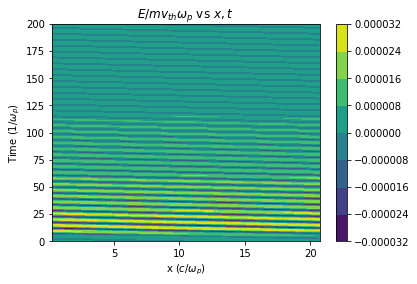

In [3]:
plt.figure()
plt.contourf(x,t_store,field_store)
plt.colorbar()
plt.xlabel("x ($c/\omega_p$)")
plt.ylabel("Time ($1/\omega_p$)")
plt.title("$E / m v_{th} \omega_p$ vs $x,t$")

#### We compute the spatial Fourier transform of the electric field to observe only the evolution of the first spatial-mode of the electric field and find that it has a exponential rate of decay of $-0.013$, which is approximately equal to the analytical solution within 3 digits

The observed decay rate is $\gamma_{L}$ = -0.013
The desired decay rate is $\gamma_{L}$ = -0.0126


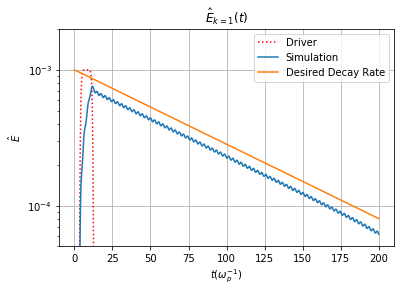

In [7]:
t_ind = -600
ek = np.fft.fft(field_store,axis=1)
ek_mag = np.array([np.abs(ek[it,1]) for it in range(nt)])
decay_rate = np.mean(np.gradient(np.log(ek_mag[-t_ind:]),0.1))
plt.figure()
plt.semilogy(t,1e-3*np.exp(-(t-8)**8./4.**8.),"r:",label="Driver")
plt.semilogy(t,ek_mag,label="Simulation")
plt.semilogy(t,1e-3*np.exp(-wi*t),label="Desired Decay Rate")
plt.ylim(5e-5,2e-3)
plt.legend()
plt.grid()
plt.ylabel("$\hat{E}$")
plt.xlabel("$t (\omega_p^{-1})$")
plt.title("$\hat{E}_{k=1}(t)$")
print ("The observed decay rate is $\gamma_{L}$ = " + str(round(decay_rate,4)))
print ("The desired decay rate is $\gamma_{L}$ = " + str(-round(wi,4)))


#### We compute the temporal Fourier transform to examine the frequency spectrum of the electric field. We find that this is approximately the driven, and resonant, frequency within 3 digits.

The observed peak is at $\omega$ = 1.1304
The desired peak is at $\omega$ = 1.1598


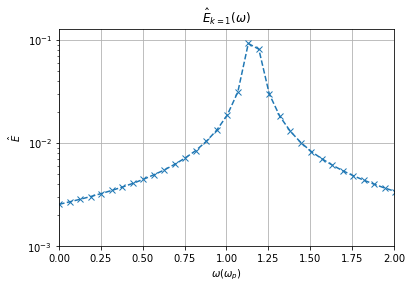

In [5]:
ekw = np.fft.fft2(field_store[nt//2:,])
ek1w = np.abs(ekw[:,1])
wax = np.fft.fftfreq(ek1w.shape[0], d=dt)*2*np.pi

plt.figure()
plt.semilogy(wax, ek1w, "--x")
plt.grid()
plt.xlim(-0, 2)
plt.ylim(1e-3,)
plt.ylabel("$\hat{E}$")
plt.xlabel("$\omega (\omega_p)$")
plt.title("$\hat{E}_{k=1}(\omega)$")
print ("The observed peak is at $\omega$ = " + str(round(wax[ek1w.argmax()],4)))
print ("The desired peak is at $\omega$ = " + str(round(w0,4)))
